In [1]:
using Turing, Distributions, Random, MCMCChains, Plots, StatsPlots, Measures
# Random seed for reproducibility
Random.seed!(1234)

TaskLocalRNG()

In [375]:
# Define the Overhypothesis model using Turing
@model function dirichlet_multinomial_model(K, I, n, y)
    # Priors
    alpha ~ truncated(Exponential(0.5), 0.1, Inf)  # Keep alpha strictly positive
    beta ~ Dirichlet([0.5, 0.5])  # Prior for the base distribution

    # Small positive constant to ensure all values are positive
    epsilon = 1e-6

    # Container-specific color distributions
    theta = Vector{Vector{Real}}(undef, I)
    for i in 1:I
        concentration_param = alpha * beta .+ epsilon
        
        # Safeguard: check if concentration_param contains Inf or NaN values
        if any(isinf.(concentration_param)) || any(isnan.(concentration_param)) || any(concentration_param .<= 0)
            error("Invalid concentration parameters detected: ", concentration_param)
        end

        theta[i] ~ Dirichlet(concentration_param)

        # Ensure theta[i] values are above a minimum threshold
        min_threshold = 1e-6
        theta[i] = [max(val, min_threshold) for val in theta[i]]

        # Normalize theta[i] to make sure it sums to 1
        theta_sum = sum(theta[i])
        theta[i] = theta[i] / theta_sum

        # Ensure that theta[i] is a valid probability vector
        if any(isnan.(theta[i])) || any(theta[i] .< 0) || abs(sum(theta[i]) - 1.0) > epsilon
            error("Invalid probability vector detected: ", theta[i])
        end

        y[i, :] ~ Multinomial(n[i], theta[i])
    end
end


dirichlet_multinomial_model (generic function with 2 methods)

In [73]:
#Mixed group data
sample_vectors_mixed = [
    [0, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2],  
    [0, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1],  
    [0, 1, 1, 2, 2, 1, 1, 2, 2, 1, 2], 
    [0, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2],  
    [0, 1, 2, 2, 1, 1, 2, 1, 2, 1, 2], 
    [0, 2, 2, 1, 1, 2, 2, 1, 1, 1, 2], 
    [0, 1, 1, 1, 2, 2, 2, 1, 2, 1, 2],  
    [0, 2, 2, 1, 2, 2, 1, 2, 1, 1, 2],  
    [0, 1, 2, 1, 2, 2, 1, 2, 1, 1, 1], 
    [0, 2, 1, 1, 2, 1, 2, 1, 1, 2, 2],  
    [0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
]


11-element Vector{Vector{Int64}}:
 [0, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2]
 [0, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1]
 [0, 1, 1, 2, 2, 1, 1, 2, 2, 1, 2]
 [0, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2]
 [0, 1, 2, 2, 1, 1, 2, 1, 2, 1, 2]
 [0, 2, 2, 1, 1, 2, 2, 1, 1, 1, 2]
 [0, 1, 1, 1, 2, 2, 2, 1, 2, 1, 2]
 [0, 2, 2, 1, 2, 2, 1, 2, 1, 1, 2]
 [0, 1, 2, 1, 2, 2, 1, 2, 1, 1, 1]
 [0, 2, 1, 1, 2, 1, 2, 1, 1, 2, 2]
 [0, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [7]:
#Uniform group data
sample_vectors_uniform = [
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],  
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],  
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],  
    [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], 
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],  
    [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],  
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],  
    [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],  
    [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], 
    [0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]  #Test
]

11-element Vector{Vector{Int64}}:
 [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
 [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
 [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
 [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
 [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
 [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
 [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
 [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
 [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
 [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
 [0, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [359]:
# Function to fit the model incrementally using the subsets, plus an additional test2 container
function fit_dynamic_model_test(sample_vectors)
    subset_index = 1
    n_containers = length(sample_vectors)
    all_posteriors = []

    # Iterate through each container and build up the subsets
    for container_index in 1:length(sample_vectors) #For each container
        for sample_index in 1:length(sample_vectors[container_index]) #For each sample 
            # Build the current subset
            subset = [i < container_index ? sample_vectors[i] : sample_vectors[i][1:sample_index] for i in 1:container_index]

            # Prepare the counts (y) for the model
            I = length(subset)  # Number of containers in the subset
            K = 2  # Number of item types (2; Low and High value in this case)
            y = [zeros(Int, K) for _ in 1:I]  # Initialize y based on K

            # Populate y based on the current subset
            for i in 1:I
                for val in subset[i]
                    if val == 1
                        y[i][1] += 1  # First category (e.g., Low-value)
                    elseif val == 2
                        y[i][2] += 1  # Second category (e.g., High-value)
                    elseif val == 0
                        y = y #A zero indicates an empty draw
                    else
                        error("Invalid sample value: $val. Must be 0, 1 or 2.")
                    end
                end
            end

            # Prepare n based on the current subset
            n = [length(s)-1 for s in subset]  # Total counts for each container in the subset
            
            #If the current container is the test1 container (i.e. last container)
            if I == length(sample_vectors)
                push!(y, [0,0]) #Append a new container (test2), with no observation
                push!(n, 0) #Count items in new container (always 0)
                I = I+1 #Lengthen I by the additional container
            end
            
            # Print the current subset and the corresponding y element
            println("Subset $subset_index: $subset")
            println("y element for model: $y")
            println("I: $I")
            println("n: $n\n")

            # Fit the model with the current subset
            model = dirichlet_multinomial_model(K, I, n, y)
            chain = sample(model, NUTS(), 1000, progress = false)

            # Store the posterior samples in a dictionary
            posterior_samples = Dict()
            for param in names(chain)
                posterior_samples[string(param)] = chain[param]
            end
            push!(all_posteriors, posterior_samples)

            subset_index += 1
        end
    end
    
    return all_posteriors
end

fit_dynamic_model_test (generic function with 1 method)

In [361]:
# Fit the model with the sample_vectors
all_posteriors_uniform = fit_dynamic_model_test(sample_vectors_uniform)
all_posteriors_mixed = fit_dynamic_model_test(sample_vectors_mixed)

Subset 1: [[0]]
y element for model: [[0, 0]]
I: 1
n: [0]

Subset 2: [[0, 1]]


┌ Info: Found initial step size
└   ϵ = 3.2


y element for model: [[1, 0]]
I: 1
n: [1]

Subset 3: [[0, 1, 1]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[2, 0]]
I: 1
n: [2]

Subset 4: [[0, 1, 1, 1]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[3, 0]]
I: 1
n: [3]

Subset 5: [[0, 1, 1, 1, 1]]


┌ Info: Found initial step size
└   ϵ = 0.8125


y element for model: [[4, 0]]
I: 1
n: [4]

Subset 6: [[0, 1, 1, 1, 1, 1]]


┌ Info: Found initial step size
└   ϵ = 3.2


y element for model: [[5, 0]]
I: 1
n: [5]

Subset 7: [[0, 1, 1, 1, 1, 1, 1]]


┌ Info: Found initial step size
└   ϵ = 0.8


y element for model: [[6, 0]]
I: 1
n: [6]

Subset 8: [[0, 1, 1, 1, 1, 1, 1, 1]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[7, 0]]
I: 1
n: [7]

Subset 9: [[0, 1, 1, 1, 1, 1, 1, 1, 1]]


┌ Info: Found initial step size
└   ϵ = 3.2


y element for model: [[8, 0]]
I: 1
n: [8]

Subset 10: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1]]


┌ Info: Found initial step size
└   ϵ = 0.8


y element for model: [[9, 0]]
I: 1
n: [9]

Subset 11: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]


┌ Info: Found initial step size
└   ϵ = 1.6500000000000001


y element for model: [[10, 0]]
I: 1
n: [10]

Subset 12: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 0]]
I: 2
n: [10, 0]

Subset 13: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 1]]
I: 2
n: [10, 1]

Subset 14: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 2]]
I: 2
n: [10, 2]

Subset 15: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 3]]
I: 2
n: [10, 3]

Subset 16: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 4]]
I: 2
n: [10, 4]

Subset 17: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 5]]
I: 2
n: [10, 5]

Subset 18: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 6]]
I: 2
n: [10, 6]

Subset 19: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 7]]
I: 2
n: [10, 7]

Subset 20: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2]]


┌ Info: Found initial step size
└   ϵ = 0.8


y element for model: [[10, 0], [0, 8]]
I: 2
n: [10, 8]

Subset 21: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 9]]
I: 2
n: [10, 9]

Subset 22: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 10]]
I: 2
n: [10, 10]

Subset 23: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 10], [0, 0]]
I: 3
n: [10, 10, 0]

Subset 24: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 10], [1, 0]]
I: 3
n: [10, 10, 1]

Subset 25: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 10], [2, 0]]
I: 3
n: [10, 10, 2]

Subset 26: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 10], [3, 0]]
I: 3
n: [10, 10, 3]

Subset 27: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 10], [4, 0]]
I: 3
n: [10, 10, 4]

Subset 28: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 10], [5, 0]]
I: 3
n: [10, 10, 5]

Subset 29: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 10], [6, 0]]
I: 3
n: [10, 10, 6]

Subset 30: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 10], [7, 0]]
I: 3
n: [10, 10, 7]

Subset 31: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 10], [8, 0]]
I: 3
n: [10, 10, 8]

Subset 32: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 10], [9, 0]]
I: 3
n: [10, 10, 9]

Subset 33: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 10], [10, 0]]
I: 3
n: [10, 10, 10]

Subset 34: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 10], [10, 0], [0, 0]]
I: 4
n: [10, 10, 10, 0]

Subset 35: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 10], [10, 0], [1, 0]]
I: 4
n: [10, 10, 10, 1]

Subset 36: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 10], [10, 0], [2, 0]]
I: 4
n: [10, 10, 10, 2]

Subset 37: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 10], [10, 0], [3, 0]]
I: 4
n: [10, 10, 10, 3]

Subset 38: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1]]


┌ Info: Found initial step size
└   ϵ = 0.8


y element for model: [[10, 0], [0, 10], [10, 0], [4, 0]]
I: 4
n: [10, 10, 10, 4]

Subset 39: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 10], [10, 0], [5, 0]]
I: 4
n: [10, 10, 10, 5]

Subset 40: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 10], [10, 0], [6, 0]]
I: 4
n: [10, 10, 10, 6]

Subset 41: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 10], [10, 0], [7, 0]]
I: 4
n: [10, 10, 10, 7]

Subset 42: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 10], [10, 0], [8, 0]]
I: 4
n: [10, 10, 10, 8]

Subset 43: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1]]


┌ Info: Found initial step size
└   ϵ = 0.8


y element for model: [[10, 0], [0, 10], [10, 0], [9, 0]]
I: 4
n: [10, 10, 10, 9]

Subset 44: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0]]
I: 4
n: [10, 10, 10, 10]

Subset 45: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0]]


┌ Info: Found initial step size
└   ϵ = 0.8


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 0]]
I: 5
n: [10, 10, 10, 10, 0]

Subset 46: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 1]]
I: 5
n: [10, 10, 10, 10, 1]

Subset 47: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 2]]
I: 5
n: [10, 10, 10, 10, 2]

Subset 48: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 3]]
I: 5
n: [10, 10, 10, 10, 3]

Subset 49: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 4]]
I: 5
n: [10, 10, 10, 10, 4]

Subset 50: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 5]]
I: 5
n: [10, 10, 10, 10, 5]

Subset 51: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 6]]
I: 5
n: [10, 10, 10, 10, 6]

Subset 52: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 7]]
I: 5
n: [10, 10, 10, 10, 7]

Subset 53: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 8]]
I: 5
n: [10, 10, 10, 10, 8]

Subset 54: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 9]]
I: 5
n: [10, 10, 10, 10, 9]

Subset 55: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 10]]
I: 5
n: [10, 10, 10, 10, 10]

Subset 56: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 10], [0, 0]]
I: 6
n: [10, 10, 10, 10, 10, 0]

Subset 57: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1]]


┌ Info: Found initial step size
└   ϵ = 0.8


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 10], [1, 0]]
I: 6
n: [10, 10, 10, 10, 10, 1]

Subset 58: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 10], [2, 0]]
I: 6
n: [10, 10, 10, 10, 10, 2]

Subset 59: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 10], [3, 0]]
I: 6
n: [10, 10, 10, 10, 10, 3]

Subset 60: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 10], [4, 0]]
I: 6
n: [10, 10, 10, 10, 10, 4]

Subset 61: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1]]


┌ Info: Found initial step size
└   ϵ = 0.4


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 10], [5, 0]]
I: 6
n: [10, 10, 10, 10, 10, 5]

Subset 62: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 10], [6, 0]]
I: 6
n: [10, 10, 10, 10, 10, 6]

Subset 63: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 10], [7, 0]]
I: 6
n: [10, 10, 10, 10, 10, 7]

Subset 64: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 10], [8, 0]]
I: 6
n: [10, 10, 10, 10, 10, 8]

Subset 65: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 10], [9, 0]]
I: 6
n: [10, 10, 10, 10, 10, 9]

Subset 66: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 10], [10, 0]]
I: 6
n: [10, 10, 10, 10, 10, 10]

Subset 67: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 10], [10, 0], [0, 0]]
I: 7
n: [10, 10, 10, 10, 10, 10, 0]

Subset 68: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2]]


┌ Info: Found initial step size
└   ϵ = 0.8


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 10], [10, 0], [0, 1]]
I: 7
n: [10, 10, 10, 10, 10, 10, 1]

Subset 69: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2]]


┌ Info: Found initial step size
└   ϵ = 0.8


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 10], [10, 0], [0, 2]]
I: 7
n: [10, 10, 10, 10, 10, 10, 2]

Subset 70: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 10], [10, 0], [0, 3]]
I: 7
n: [10, 10, 10, 10, 10, 10, 3]

Subset 71: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 10], [10, 0], [0, 4]]
I: 7
n: [10, 10, 10, 10, 10, 10, 4]

Subset 72: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 10], [10, 0], [0, 5]]
I: 7
n: [10, 10, 10, 10, 10, 10, 5]

Subset 73: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 10], [10, 0], [0, 6]]
I: 7
n: [10, 10, 10, 10, 10, 10, 6]

Subset 74: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 10], [10, 0], [0, 7]]
I: 7
n: [10, 10, 10, 10, 10, 10, 7]

Subset 75: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 10], [10, 0], [0, 8]]
I: 7
n: [10, 10, 10, 10, 10, 10, 8]

Subset 76: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 10], [10, 0], [0, 9]]
I: 7
n: [10, 10, 10, 10, 10, 10, 9]

Subset 77: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 10], [10, 0], [0, 10]]
I: 7
n: [10, 10, 10, 10, 10, 10, 10]

Subset 78: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 10], [10, 0], [0, 10], [0, 0]]
I: 8
n: [10, 10, 10, 10, 10, 10, 10, 0]

Subset 79: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 10], [10, 0], [0, 10], [1, 0]]
I: 8
n: [10, 10, 10, 10, 10, 10, 10, 1]

Subset 80: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 10], [10, 0], [0, 10], [2, 0]]
I: 8
n: [10, 10, 10, 10, 10, 10, 10, 2]

Subset 81: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 10], [10, 0], [0, 10], [3, 0]]
I: 8
n: [10, 10, 10, 10, 10, 10, 10, 3]

Subset 82: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 10], [10, 0], [0, 10], [4, 0]]
I: 8
n: [10, 10, 10, 10, 10, 10, 10, 4]

Subset 83: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1]]


┌ Info: Found initial step size
└   ϵ = 0.8


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 10], [10, 0], [0, 10], [5, 0]]
I: 8
n: [10, 10, 10, 10, 10, 10, 10, 5]

Subset 84: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1]]


┌ Info: Found initial step size
└   ϵ = 0.8


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 10], [10, 0], [0, 10], [6, 0]]
I: 8
n: [10, 10, 10, 10, 10, 10, 10, 6]

Subset 85: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1]]


┌ Info: Found initial step size
└   ϵ = 0.8


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 10], [10, 0], [0, 10], [7, 0]]
I: 8
n: [10, 10, 10, 10, 10, 10, 10, 7]

Subset 86: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 10], [10, 0], [0, 10], [8, 0]]
I: 8
n: [10, 10, 10, 10, 10, 10, 10, 8]

Subset 87: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1]]


┌ Info: Found initial step size
└   ϵ = 0.8


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 10], [10, 0], [0, 10], [9, 0]]
I: 8
n: [10, 10, 10, 10, 10, 10, 10, 9]

Subset 88: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 10], [10, 0], [0, 10], [10, 0]]
I: 8
n: [10, 10, 10, 10, 10, 10, 10, 10]

Subset 89: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 10], [10, 0], [0, 10], [10, 0], [0, 0]]
I: 9
n: [10, 10, 10, 10, 10, 10, 10, 10, 0]

Subset 90: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 10], [10, 0], [0, 10], [10, 0], [0, 1]]
I: 9
n: [10, 10, 10, 10, 10, 10, 10, 10, 1]

Subset 91: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2]]


┌ Info: Found initial step size
└   ϵ = 0.8


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 10], [10, 0], [0, 10], [10, 0], [0, 2]]
I: 9
n: [10, 10, 10, 10, 10, 10, 10, 10, 2]

Subset 92: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 10], [10, 0], [0, 10], [10, 0], [0, 3]]
I: 9
n: [10, 10, 10, 10, 10, 10, 10, 10, 3]

Subset 93: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 10], [10, 0], [0, 10], [10, 0], [0, 4]]
I: 9
n: [10, 10, 10, 10, 10, 10, 10, 10, 4]

Subset 94: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 10], [10, 0], [0, 10], [10, 0], [0, 5]]
I: 9
n: [10, 10, 10, 10, 10, 10, 10, 10, 5]

Subset 95: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2]]


┌ Info: Found initial step size
└   ϵ = 0.8


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 10], [10, 0], [0, 10], [10, 0], [0, 6]]
I: 9
n: [10, 10, 10, 10, 10, 10, 10, 10, 6]

Subset 96: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2]]


┌ Info: Found initial step size
└   ϵ = 0.8


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 10], [10, 0], [0, 10], [10, 0], [0, 7]]
I: 9
n: [10, 10, 10, 10, 10, 10, 10, 10, 7]

Subset 97: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 10], [10, 0], [0, 10], [10, 0], [0, 8]]
I: 9
n: [10, 10, 10, 10, 10, 10, 10, 10, 8]

Subset 98: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 10], [10, 0], [0, 10], [10, 0], [0, 9]]
I: 9
n: [10, 10, 10, 10, 10, 10, 10, 10, 9]

Subset 99: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 10], [10, 0], [0, 10], [10, 0], [0, 10]]
I: 9
n: [10, 10, 10, 10, 10, 10, 10, 10, 10]

Subset 100: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 10], [10, 0], [0, 10], [10, 0], [0, 10], [0, 0]]
I: 10
n: [10, 10, 10, 10, 10, 10, 10, 10, 10, 0]

Subset 101: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 2]]


┌ Info: Found initial step size
└   ϵ = 0.4


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 10], [10, 0], [0, 10], [10, 0], [0, 10], [0, 1]]
I: 10
n: [10, 10, 10, 10, 10, 10, 10, 10, 10, 1]

Subset 102: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 2, 2]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 10], [10, 0], [0, 10], [10, 0], [0, 10], [0, 2]]
I: 10
n: [10, 10, 10, 10, 10, 10, 10, 10, 10, 2]

Subset 103: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 2, 2, 2]]


┌ Info: Found initial step size
└   ϵ = 0.8


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 10], [10, 0], [0, 10], [10, 0], [0, 10], [0, 3]]
I: 10
n: [10, 10, 10, 10, 10, 10, 10, 10, 10, 3]

Subset 104: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 2, 2, 2, 2]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 10], [10, 0], [0, 10], [10, 0], [0, 10], [0, 4]]
I: 10
n: [10, 10, 10, 10, 10, 10, 10, 10, 10, 4]

Subset 105: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 2, 2, 2, 2, 2]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 10], [10, 0], [0, 10], [10, 0], [0, 10], [0, 5]]
I: 10
n: [10, 10, 10, 10, 10, 10, 10, 10, 10, 5]

Subset 106: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 2, 2, 2, 2, 2, 2]]


┌ Info: Found initial step size
└   ϵ = 0.8


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 10], [10, 0], [0, 10], [10, 0], [0, 10], [0, 6]]
I: 10
n: [10, 10, 10, 10, 10, 10, 10, 10, 10, 6]

Subset 107: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 2, 2, 2, 2, 2, 2, 2]]


┌ Info: Found initial step size
└   ϵ = 0.8


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 10], [10, 0], [0, 10], [10, 0], [0, 10], [0, 7]]
I: 10
n: [10, 10, 10, 10, 10, 10, 10, 10, 10, 7]

Subset 108: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 2, 2, 2, 2, 2, 2, 2, 2]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 10], [10, 0], [0, 10], [10, 0], [0, 10], [0, 8]]
I: 10
n: [10, 10, 10, 10, 10, 10, 10, 10, 10, 8]

Subset 109: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 10], [10, 0], [0, 10], [10, 0], [0, 10], [0, 9]]
I: 10
n: [10, 10, 10, 10, 10, 10, 10, 10, 10, 9]

Subset 110: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 10], [10, 0], [0, 10], [10, 0], [0, 10], [0, 10]]
I: 10
n: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10]

Subset 111: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 10], [10, 0], [0, 10], [10, 0], [0, 10], [0, 10], [0, 0], [0, 0]]
I: 12
n: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0]

Subset 112: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 10], [10, 0], [0, 10], [10, 0], [0, 10], [0, 10], [1, 0], [0, 0]]
I: 12
n: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1, 0]

Subset 113: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1]]


┌ Info: Found initial step size
└   ϵ = 0.8


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 10], [10, 0], [0, 10], [10, 0], [0, 10], [0, 10], [2, 0], [0, 0]]
I: 12
n: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 2, 0]

Subset 114: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1]]


┌ Info: Found initial step size
└   ϵ = 0.8


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 10], [10, 0], [0, 10], [10, 0], [0, 10], [0, 10], [3, 0], [0, 0]]
I: 12
n: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 3, 0]

Subset 115: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1]]


┌ Info: Found initial step size
└   ϵ = 0.8


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 10], [10, 0], [0, 10], [10, 0], [0, 10], [0, 10], [4, 0], [0, 0]]
I: 12
n: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 4, 0]

Subset 116: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1]]


┌ Info: Found initial step size
└   ϵ = 0.8


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 10], [10, 0], [0, 10], [10, 0], [0, 10], [0, 10], [5, 0], [0, 0]]
I: 12
n: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 5, 0]

Subset 117: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1]]


┌ Info: Found initial step size
└   ϵ = 0.8


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 10], [10, 0], [0, 10], [10, 0], [0, 10], [0, 10], [6, 0], [0, 0]]
I: 12
n: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 6, 0]

Subset 118: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 10], [10, 0], [0, 10], [10, 0], [0, 10], [0, 10], [7, 0], [0, 0]]
I: 12
n: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 7, 0]

Subset 119: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 10], [10, 0], [0, 10], [10, 0], [0, 10], [0, 10], [8, 0], [0, 0]]
I: 12
n: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 8, 0]

Subset 120: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1]]


┌ Info: Found initial step size
└   ϵ = 0.8


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 10], [10, 0], [0, 10], [10, 0], [0, 10], [0, 10], [9, 0], [0, 0]]
I: 12
n: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 0]

Subset 121: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]


┌ Info: Found initial step size
└   ϵ = 0.8


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 10], [10, 0], [0, 10], [10, 0], [0, 10], [0, 10], [10, 0], [0, 0]]
I: 12
n: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0]

Subset 122: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]


┌ Info: Found initial step size
└   ϵ = 0.8


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 10], [10, 0], [0, 10], [10, 0], [0, 10], [0, 10], [11, 0], [0, 0]]
I: 12
n: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 0]

Subset 123: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]


┌ Info: Found initial step size
└   ϵ = 0.8


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 10], [10, 0], [0, 10], [10, 0], [0, 10], [0, 10], [12, 0], [0, 0]]
I: 12
n: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 12, 0]

Subset 124: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]


┌ Info: Found initial step size
└   ϵ = 0.8


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 10], [10, 0], [0, 10], [10, 0], [0, 10], [0, 10], [13, 0], [0, 0]]
I: 12
n: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 13, 0]

Subset 125: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 10], [10, 0], [0, 10], [10, 0], [0, 10], [0, 10], [14, 0], [0, 0]]
I: 12
n: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 14, 0]

Subset 126: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]


┌ Info: Found initial step size
└   ϵ = 0.8


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 10], [10, 0], [0, 10], [10, 0], [0, 10], [0, 10], [15, 0], [0, 0]]
I: 12
n: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 15, 0]

Subset 127: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 10], [10, 0], [0, 10], [10, 0], [0, 10], [0, 10], [16, 0], [0, 0]]
I: 12
n: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 16, 0]

Subset 128: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]


┌ Info: Found initial step size
└   ϵ = 0.8


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 10], [10, 0], [0, 10], [10, 0], [0, 10], [0, 10], [17, 0], [0, 0]]
I: 12
n: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 17, 0]

Subset 129: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 10], [10, 0], [0, 10], [10, 0], [0, 10], [0, 10], [18, 0], [0, 0]]
I: 12
n: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 18, 0]

Subset 130: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]


┌ Info: Found initial step size
└   ϵ = 0.8


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 10], [10, 0], [0, 10], [10, 0], [0, 10], [0, 10], [19, 0], [0, 0]]
I: 12
n: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 19, 0]

Subset 131: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]


┌ Info: Found initial step size
└   ϵ = 0.8


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 10], [10, 0], [0, 10], [10, 0], [0, 10], [0, 10], [20, 0], [0, 0]]
I: 12
n: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 20, 0]

Subset 132: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]


┌ Info: Found initial step size
└   ϵ = 0.8


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 10], [10, 0], [0, 10], [10, 0], [0, 10], [0, 10], [21, 0], [0, 0]]
I: 12
n: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 21, 0]

Subset 133: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 10], [10, 0], [0, 10], [10, 0], [0, 10], [0, 10], [22, 0], [0, 0]]
I: 12
n: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 22, 0]

Subset 134: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 10], [10, 0], [0, 10], [10, 0], [0, 10], [0, 10], [23, 0], [0, 0]]
I: 12
n: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 23, 0]

Subset 135: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]


┌ Info: Found initial step size
└   ϵ = 0.8


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 10], [10, 0], [0, 10], [10, 0], [0, 10], [0, 10], [24, 0], [0, 0]]
I: 12
n: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 24, 0]

Subset 136: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 10], [10, 0], [0, 10], [10, 0], [0, 10], [0, 10], [25, 0], [0, 0]]
I: 12
n: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 25, 0]

Subset 137: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]


┌ Info: Found initial step size
└   ϵ = 0.8


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 10], [10, 0], [0, 10], [10, 0], [0, 10], [0, 10], [26, 0], [0, 0]]
I: 12
n: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 26, 0]

Subset 138: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 10], [10, 0], [0, 10], [10, 0], [0, 10], [0, 10], [27, 0], [0, 0]]
I: 12
n: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 27, 0]

Subset 139: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]


┌ Info: Found initial step size
└   ϵ = 1.6


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 10], [10, 0], [0, 10], [10, 0], [0, 10], [0, 10], [28, 0], [0, 0]]
I: 12
n: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 28, 0]

Subset 140: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]


┌ Info: Found initial step size
└   ϵ = 0.8


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 10], [10, 0], [0, 10], [10, 0], [0, 10], [0, 10], [29, 0], [0, 0]]
I: 12
n: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 29, 0]

Subset 141: [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]


┌ Info: Found initial step size
└   ϵ = 0.8


y element for model: [[10, 0], [0, 10], [10, 0], [10, 0], [0, 10], [10, 0], [0, 10], [10, 0], [0, 10], [0, 10], [30, 0], [0, 0]]
I: 12
n: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 30, 0]



┌ Info: Found initial step size
└   ϵ = 0.8


141-element Vector{Any}:
 Dict{Any, Any}("theta[1][1]" => [0.5106124987473839; 0.329026444530441; … ; 0.9998094200431218; 0.9999953469544844;;], "tree_depth" => [2.0; 2.0; … ; 2.0; 2.0;;], "hamiltonian_energy" => [8.689785342389726; 7.914777260043673; … ; 9.25270141849566; 10.814495719455206;;], "acceptance_rate" => [0.8; 0.6645246006652897; … ; 0.4775812443568981; 0.21074812861266037;;], "log_density" => [-5.192169272584364; -6.129332139623257; … ; -7.571985769680326; -9.798292566144703;;], "hamiltonian_energy_error" => [-0.755462922497868; 0.3250052473314886; … ; 0.0992542125232081; 0.21382774101005353;;], "beta[1]" => [0.5204247005525175; 0.12613191013317226; … ; 0.9602063324270684; 0.9907554101673243;;], "nom_step_size" => [0.5175861374120557; 0.5175861374120557; … ; 0.5175861374120557; 0.5175861374120557;;], "alpha" => [0.5106031523053686; 0.6751033418543129; … ; 1.0639896193931442; 0.5762253058523007;;], "is_accept" => [1.0; 1.0; … ; 1.0; 1.0;;]…)
 Dict{Any, Any}("theta[1][1]" =>

[ Info: Saved animation to /Users/aruf650/Library/CloudStorage/OneDrive-Personal/Uni/PhD/Research/Overhypothesis/Analysis/Cognitive_Model/Julia/theta_evolution_full.gif


Plots.AnimatedGif("/Users/aruf650/Library/CloudStorage/OneDrive-Personal/Uni/PhD/Research/Overhypothesis/Analysis/Cognitive_Model/Julia/theta_evolution_full.gif")
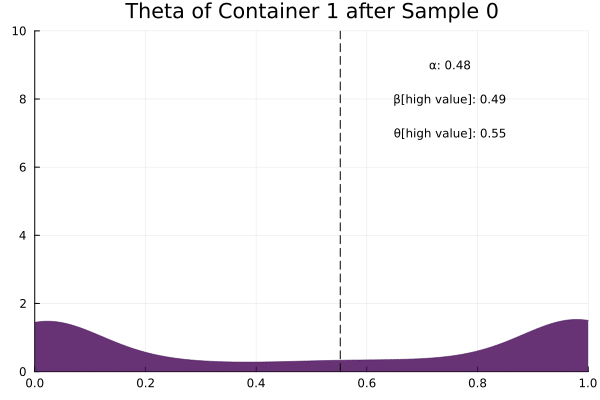

In [391]:
all_posteriors = copy(all_posteriors_mixed)
sample_vectors = copy(sample_vectors_mixed)

n_samples = sum([length(s) for s in sample_vectors])
n_containers = length(sample_vectors)

# Combined function to create current_container and current_sample indices
function create_indices(sample_vectors::Vector{Vector{Int}})
    current_container = Int[]  # Initialize an empty array to hold the container indices
    current_sample = Int[]     # Initialize an empty array to hold the sample indices

    # Iterate through each container and its samples
    for (container_index, samples) in enumerate(sample_vectors)
        # Append the container index for each sample in the container
        append!(current_container, [container_index for _ in samples])

        # Append the sample index for each sample in the container
        append!(current_sample, [i-1 for i in 1:length(samples)])
    end

    return current_container, current_sample
end

current_container, current_sample = create_indices(sample_vectors)

test1 = copy(current_container)
test2 = copy(current_container)

#This replaces the last container (test1) with the last container + 1 (test2)
test2 = append!(test2[1:end-length(sample_vectors[end])], fill(current_container[end]+1, length(sample_vectors[end])))

current_container = test2

# Function to animate the evolution of theta posteriors for the last container in each iteration
function animate_theta_evolution_all_containers(all_posteriors, current_container)
    #Define current_container
    current_container = current_container
    # Define a color palette for the containers
    container_colors = palette(:viridis, n_containers+1)

    # Create an animation object
    anim = @animate for i in 1:n_samples
        # Extract the samples for theta of the last container
        last_container = current_container[i]
        last_sample = current_sample[i]
        theta_samples = vec(all_posteriors[i]["theta[$last_container][2]"])

        # Extract alpha and beta samples for this iteration
        alpha_samples = vec(all_posteriors[i]["alpha"])
        beta_samples = vec(all_posteriors[i]["beta[2]"])  # Assuming beta[2] is the probability for white marbles

        # Calculate medians
        theta_median = median(theta_samples)
        alpha_median = median(alpha_samples)
        beta_median = median(beta_samples)

        # Get the color for the current container
        fill_color = container_colors[last_container]

        # Plot the density for the last container's theta and fill the area under the curve
        p = plot(xlims = (0, 1), ylims = (0, 10), legend = false,
                 title = "Theta of Container $last_container after Sample $last_sample")
        density!(theta_samples, fill = true, fillalpha = 0.8, alpha = 0.5, color = fill_color)

        # Show the median line for theta
        vline!([theta_median], color = :black, linestyle = :dash, linewidth = 1)
        
        # Annotate with the median values of theta, alpha, and beta
        annotate!(0.75, 9, text("α: $(round(alpha_median, digits=2))", 8))
        annotate!(0.75, 8, text("β[high value]: $(round(beta_median, digits=2))", 8))
        annotate!(0.75, 7, text("θ[high value]: $(round(theta_median, digits=2))", 8))
    end

    # Display the animation
    gif(anim, "theta_evolution_full.gif", fps = 10)
end

# Example usage
animate_theta_evolution_all_containers(all_posteriors_uniform, test2)

[ Info: Saved animation to /Users/aruf650/Library/CloudStorage/OneDrive-Personal/Uni/PhD/Research/Overhypothesis/Analysis/Cognitive_Model/Julia/theta_evolution_test.gif


Plots.AnimatedGif("/Users/aruf650/Library/CloudStorage/OneDrive-Personal/Uni/PhD/Research/Overhypothesis/Analysis/Cognitive_Model/Julia/theta_evolution_test.gif")
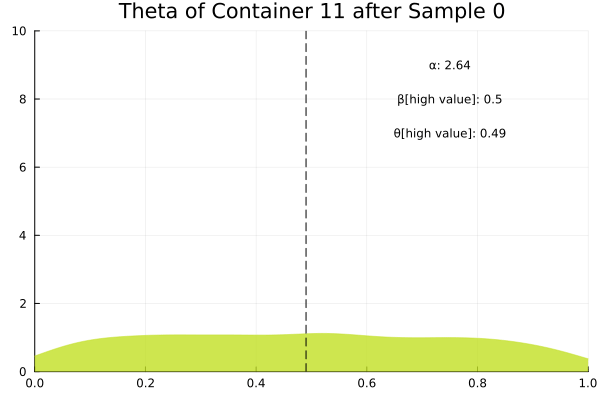

In [387]:
all_posteriors = copy(all_posteriors_mixed)
sample_vectors = copy(sample_vectors_mixed)

n_samples = sum([length(s) for s in sample_vectors])
n_containers = length(sample_vectors)

# Combined function to create current_container and current_sample indices
function create_indices(sample_vectors::Vector{Vector{Int}})
    current_container = Int[]  # Initialize an empty array to hold the container indices
    current_sample = Int[]     # Initialize an empty array to hold the sample indices

    # Iterate through each container and its samples
    for (container_index, samples) in enumerate(sample_vectors)
        # Append the container index for each sample in the container
        append!(current_container, [container_index for _ in samples])

        # Append the sample index for each sample in the container
        append!(current_sample, [i-1 for i in 1:length(samples)])
    end

    return current_container, current_sample
end

current_container, current_sample = create_indices(sample_vectors)

test1 = copy(current_container)
test2 = copy(current_container)

# This replaces the last container (test1) with the last container + 1 (test2)
test2 = append!(test2[1:end-length(sample_vectors[end])], fill(current_container[end]+1, length(sample_vectors[end])))



# Function to animate the evolution of theta posteriors for the last container in each iteration
function animate_theta_evolution_test(all_posteriors, current_container)
    #Define current_container
    current_container = current_container
    # Define a color palette for the containers
    container_colors = palette(:viridis, n_containers+1)


    start_last_container = length(current_sample)-length(sample_vectors[end])+1
    # Create an animation object
    anim = @animate for i in start_last_container:length(current_sample)
        # Extract the samples for theta of the last container
        last_container = current_container[i]
        last_sample = current_sample[i]
        theta_samples = vec(all_posteriors[i]["theta[$last_container][2]"])

        # Extract alpha and beta samples for this iteration
        alpha_samples = vec(all_posteriors[i]["alpha"])
        beta_samples = vec(all_posteriors[i]["beta[2]"])  # Assuming beta[2] is the probability for white marbles

        # Calculate medians
        theta_median = median(theta_samples)
        alpha_median = median(alpha_samples)
        beta_median = median(beta_samples)

        # Get the color for the current container
        fill_color = container_colors[last_container]

        # Plot the density for the last container's theta and fill the area under the curve
        p = plot(xlims = (0, 1), ylims = (0, 10), legend = false,
                 title = "Theta of Container $last_container after Sample $last_sample")
        density!(theta_samples, fill = true, fillalpha = 0.8, alpha = 0.5, color = fill_color)

        # Show the median line for theta
        vline!([theta_median], color = :black, linestyle = :dash, linewidth = 1)
        
        # Annotate with the median values of theta, alpha, and beta
        annotate!(0.75, 9, text("α: $(round(alpha_median, digits=2))", 8))
        annotate!(0.75, 8, text("β[high value]: $(round(beta_median, digits=2))", 8))
        annotate!(0.75, 7, text("θ[high value]: $(round(theta_median, digits=2))", 8))
    end

    # Display the animation
    gif(anim, "theta_evolution_test.gif", fps = 2)
end

# Example usage
animate_theta_evolution_test(all_posteriors_mixed, test1)